In [15]:
import pint
import os, sys

# ---------
# add lib folder to the path
def is_root(path):
    """
    Determine whether the path passed is the root directory for the file system
    """
    return not os.path.split(os.path.normpath(os.path.abspath(path)))[1]

def is_root_project_dir(path):
    """
    Determine whether the path specified is the root project directory by looking for 
    __mtk__.py in the directory. If the root file system directory is encountered, throw
    an exception
    """
    PROJECT_ROOT_FILE = '__mtk__.py'
    
    # make sure the path is in an OK format (ends with a directory separator)
    search_path = str(path)
    if (not search_path.endswith(os.sep)):
        search_path += os.sep
        
    # make sure the path isn't the root. if it is, there's a problem
    if (is_root(search_path)):
        raise Exception('Failed to locate root MTK directory (directory containint %s)' % PROJECT_ROOT_FILE)
        
    # check to see whether we can find the project root file in this path
    return os.path.isfile(search_path + PROJECT_ROOT_FILE)

def get_project_root():
    """
    Locate the project's root directory and return its location. If the root file system
    directory is encountered, throw an exception
    """
    search_path = os.getcwd() + os.sep
    count = 0
    while (not is_root_project_dir(search_path)):
        search_path = os.path.normpath(os.path.abspath(search_path + '..' + os.sep)) + os.sep
    return search_path

lib_path = get_project_root()
sys.path.insert(0, lib_path)
# ----------------

from lib.calculator import LinkBudgetCalculator
from tests.link_budget_test_case_dataset import LinkBudgetTestCaseDataset

In [16]:
ureg = pint.UnitRegistry()

# create the linkBudgetCalculator object
lb_calc = LinkBudgetCalculator(ureg)

## Analysis of Design Iteration X

### Description

<br>
TEMPLATE <br>
DESCRIPTION <br>
FOR <br>
DESIGNS <br>
<br>

![alt text](block_diagram_template.png "Block Diagram")
*<p style="text-align: center;">Block Diagram</p>*


### Setup of Ground Station Values

DESCRIBE PARAMETERS OF GROUND STATION

Values for specific ground station are below:

In [17]:
lb_calc.altitude_ground_station   =  400 * ureg.meter
lb_calc.implementation_loss       = -1.0   # dB
lb_calc.polarization_losses       =  0.0   # dB
lb_calc.receive_antenna_gain      =  5.4   # dB
lb_calc.system_noise_figure       =  5.0   # dB

### Setup of Satellite Values

Values stated for a certain NOAA satellite. These values are covered in the documentation.

In [18]:
lb_calc.altitude_satellite        =  860 * ureg.kilometer
lb_calc.transmit_power            =  5.0 * ureg.watt
lb_calc.transmit_losses           = -1.0   # dB
lb_calc.transmit_antenna_gain     =  4.0   # dBi

### Setup of Additional Values

Create functions for the changing elevation angle and atmospheric loss values.

In [19]:
def atmloss_at_elev(elev):
    return -4.6 if elev < 5  * ureg.degrees else \
           -2.1 if elev < 10 * ureg.degrees else \
           -1.1 if elev < 30 * ureg.degrees else \
           -0.4 if elev < 45 * ureg.degrees else \
           -0.3 if elev < 90 * ureg.degrees else 0.0

def rx_pointing_loss_at_elev(elev):
    return -10.0 if elev < 5  * ureg.degrees else \
           -6.0  if elev < 20 * ureg.degrees else \
           -3.0  if elev < 35 * ureg.degrees else \
           -1.0  if elev < 50 * ureg.degrees else 0.0

Set paramaters for the analysis here

In [20]:
elev_max = 90 * ureg.degrees
elev_increment = 0.1 * ureg.degrees

Additional values are needed for the channel characteristics. A few of these values will change during an orbital pass!

In [28]:
lb_calc.orbit_elevation_angle     =  elev_increment
lb_calc.downlink_frequency        =  137.5          * ureg.megahertz
lb_calc.target_energy_noise_ratio =  20.0             # dB
lb_calc.noise_bandwidth           =  34.0           * ureg.kilohertz
lb_calc.transmit_pointing_loss    = -3.0              # dB
lb_calc.atmospheric_loss          =  atmloss_at_elev(lb_calc.orbit_elevation_angle)
lb_calc.receiving_pointing_loss   =  rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

### Analysis

Define variables for running a sweep over an orbital pass.

Increment through an entire orbital pass.

In [29]:
outputs = []
angles  = []
rising  = True

# DEBUG
temp = []

while rising or lb_calc.orbit_elevation_angle.magnitude > 0:
    # compute the budget
    lb_calc.run()
    
    # ensure the computation was valid
    if not lb_calc.is_valid:
        raise Exception('Run at elevation angle ', lb_calc.orbit_elevation_angle, ' was not valid')
    
    # save output as a tuple to output list
    outputs.append( (lb_calc.link_distance, \
                     lb_calc.downlink_path_loss, \
                     lb_calc.received_power, \
                     lb_calc.energy_noise_ratio, \
                     lb_calc.link_margin) )
    angles.append( lb_calc.orbit_elevation_angle.magnitude )
    
    # handle the rising variable
    if rising:
        rising = lb_calc.orbit_elevation_angle < elev_max
    
    # increment the elevation angle
    lb_calc.orbit_elevation_angle += elev_increment if rising else -elev_increment
    lb_calc.atmospheric_loss          =  atmloss_at_elev(lb_calc.orbit_elevation_angle)
    lb_calc.receiving_pointing_loss   =  rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

Once analysis has run, examine the results.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

# extract lists of the variables
distances = [ i[0].magnitude for i in outputs ]
loss      = [ i[1] for i in outputs ]
rx_pow    = [ i[2] for i in outputs ]
eb_no     = [ i[3] for i in outputs ]
margins   = [ i[4] for i in outputs ]

# removing the last value which was zero for some reason
margins = margins[:-1]

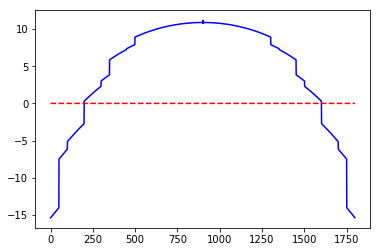

In [31]:
plt.plot(range(0, len(margins)), margins, 'b', range(0, len(margins)), [0] * len(margins), 'r--')

### Conclusions

DETAIL CONCLUSIONS FOR THIS ITERATION

PROBABLY WILL VARY GREATLY FOR EACH ITERATION